# Portfolio Optimization Study

In this notebook we explore the data and compute the portfolio

### Read processed data

In [24]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting

sns.set_theme(style="whitegrid")

csv = 'processed/data.csv'
holidays_csv = 'data/feriados_nacionais.csv'

if not os.path.isfile(csv):
    %run "./wrangle.ipynb";

# Risk free rate
RISK_FREE = pd.read_csv('data/IRLTLT01USM156N.csv', 
                        parse_dates=True, index_col='DATE').median()[0] / 100

# ticker to analyze
tickers = ['IMA-B', 'IRF-M', 'IDA Geral', 'IDA DI', 'IDA IPCA', 'IEEX', 'IFIX', 'IBOV', 
           'IDIV', 'IGCX', 'IMOB', 'INDX', 'ISEE', 'ITAG', 'IVBX', 'MLCX', 'SMLL', 'UTIL', 
           'BDRX', 'EUROBR', 'DOLOF', 'NASDAQ', 'S&P 500', 'DJIA', 'WTICO']

# start and wnd year
y1, yn = 2011, 2021

# prepare log returns of tickers
holidays = pd.read_csv(holidays_csv, sep=';', parse_dates=True, index_col='date') # get BR holidays
df = pd.read_csv(csv, parse_dates=True, index_col="Data"); # get processed data
df = df[~df.index.isin(holidays.index)].copy().ffill().fillna(0) # exclude BR holidays and forward fill
df.loc[:, 'NASDAQ':] = df.loc[:, 'NASDAQ':].mul(df['DOLOF'], axis=0) # convert to BRL
df = np.log( df / df.shift() ) # log returns
df = df.loc[str(y1):str(yn), tickers] # filter tickers only and restric years
print(f"Number of Tickers: {len(df.columns)}")
print(f"RIKS FREE RATE {RISK_FREE}")
df.describe() # descriptive statistics

Number of Tickers: 25
RIKS FREE RATE 0.0217


C:\Users\Marcus Santos\.conda\envs\portfolio\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
C:\Users\Marcus Santos\.conda\envs\portfolio\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


,IMA-B,IRF-M,IDA Geral,IDA DI,IDA IPCA,IEEX,IFIX,IBOV,IDIV,IGCX,...,MLCX,SMLL,UTIL,BDRX,EUROBR,DOLOF,NASDAQ,S&P 500,DJIA,WTICO
count,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000,...,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000,2761.000000
mean,0.000439,0.000392,0.000395,0.000371,0.000453,0.000373,0.000373,0.000150,0.000328,0.000289,...,0.000269,0.000617,0.000884,0.000963,0.000377,0.000437,0.001080,0.000920,0.000414,0.000465
std,0.005028,0.002251,0.001204,0.000438,0.002819,0.013061,0.005421,0.015859,0.014632,0.014291,...,0.015133,0.014028,0.014605,0.013522,0.009205,0.009137,0.013641,0.012317,0.010826,0.028204
min,-0.078184,-0.035463,-0.013537,-0.007170,-0.034186,-0.123209,-0.141912,-0.159938,-0.130146,-0.163415,...,-0.158263,-0.151614,-0.116618,-0.303322,-0.066199,-0.060686,-0.087843,-0.084093,-0.138435,-0.276604
25%,-0.001514,-0.000615,0.000000,0.000297,-0.000494,-0.006066,-0.001447,-0.008220,-0.007256,-0.006820,...,-0.007462,-0.006695,-0.007403,-0.004734,-0.004842,-0.004355,-0.005707,-0.005392,-0.003292,-0.010742
50%,0.000543,0.000450,0.000468,0.000390,0.000536,0.000524,0.000413,0.000167,0.000301,0.000383,...,0.000114,0.000543,0.001128,0.000885,0.000323,0.000294,0.001149,0.001071,0.000448,0.000832
75%,0.002643,0.001456,0.000841,0.000494,0.001596,0.007318,0.002406,0.008888,0.008153,0.007820,...,0.008464,0.008446,0.009123,0.007025,0.005331,0.005122,0.008405,0.007259,0.005216,0.011938
max,0.052596,0.018925,0.010637,0.003967,0.028262,0.086076,0.056587,0.130228,0.097377,0.126321,...,0.130528,0.080402,0.073724,0.275915,0.083868,0.084232,0.091507,0.087912,0.107643,0.382326


### Explore Correlations

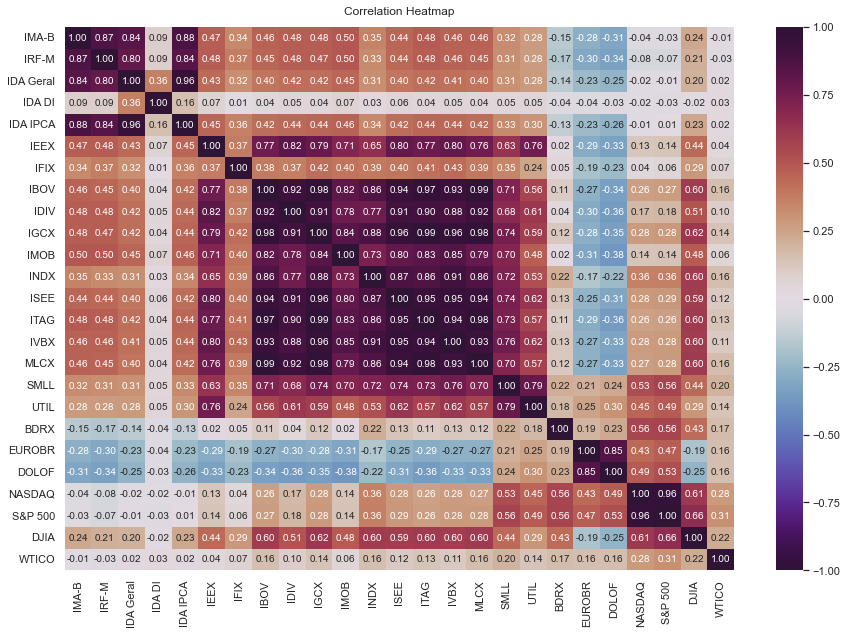

In [2]:
plt.figure(figsize=(15, 10))
phi = df.loc[:str(yn+2)].corr()
h = sns.heatmap(phi, annot=True, fmt='.2f', vmin=-1, vmax=1, cmap='twilight_shifted');
h.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

### Drop correlations $ \leq -0,7 or \geq 0.7 $

Number of Tickers: 8


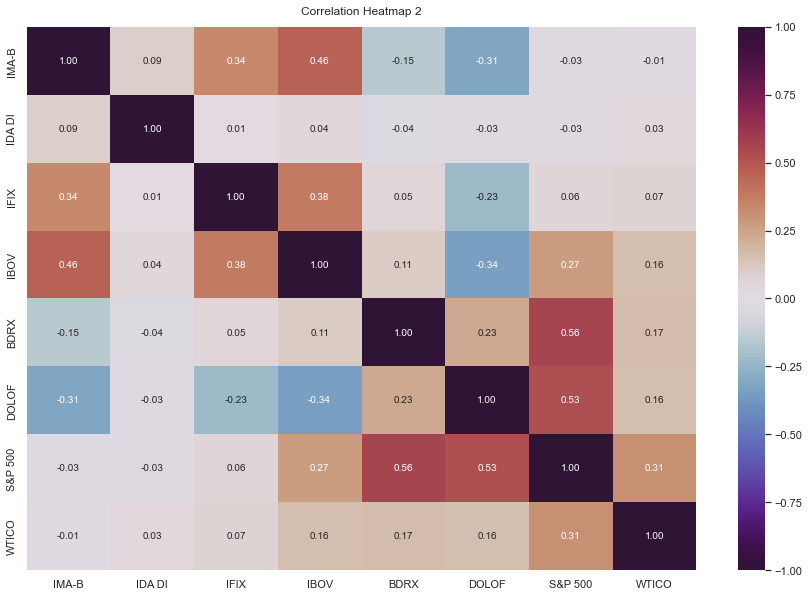

In [3]:
# ticker to exclude with corr >= 0.7
exclude = ['IRF-M', 'IDA Geral', 'IDA IPCA', 'UTIL', 'IDIV', 'IEEX' ,'IGCX', 'IMOB', 
           'INDX', 'ISEE', 'ITAG', 'IVBX', 'MLCX', 'SMLL', 'EUROBR', 'DJIA', 'NASDAQ']

plt.figure(figsize=(15, 10))
df2 = df.drop(columns=exclude)
phi = df2.loc[:str(yn+2)].corr()
print(f"Number of Tickers: {len(df2.columns)}")
h = sns.heatmap(phi, annot=True, fmt='.2f', vmin=-1, vmax=1, cmap='twilight_shifted');
h.set_title('Correlation Heatmap 2', fontdict={'fontsize':12}, pad=12);

### Estimate Portfolio Variance

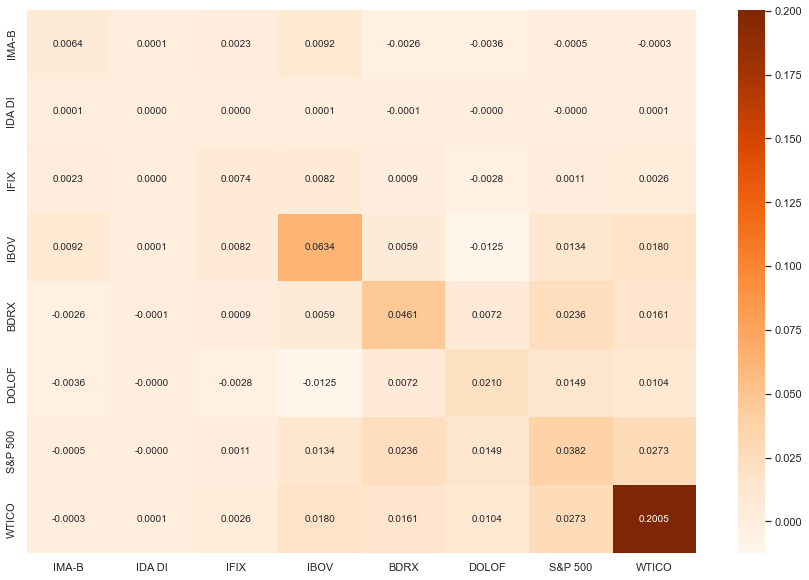

In [4]:
S = risk_models.sample_cov(df2.loc[:str(yn+2)], returns_data=True)
plt.figure(figsize=(15, 10));
sns.heatmap(S, annot=True, fmt='.4f', cmap='Oranges');

### Remove `IDA DI` wich represents no risk in portfolio

Number of Tickers: 7


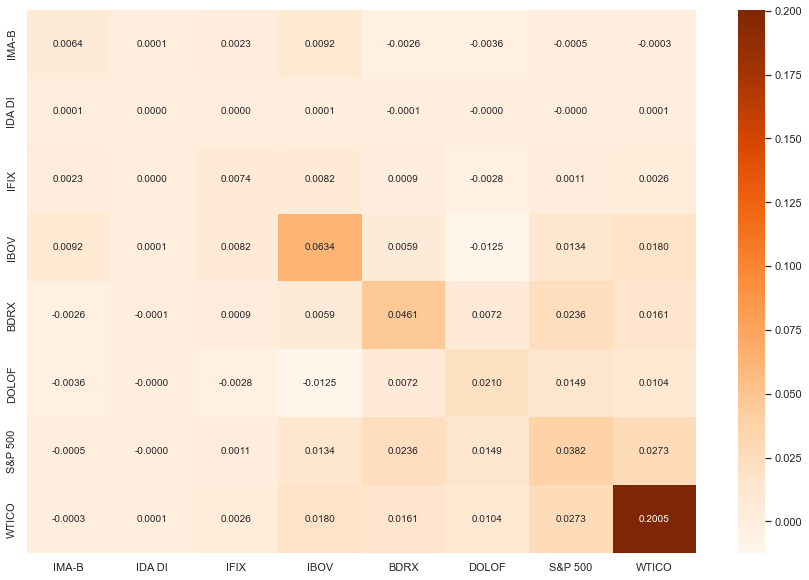

In [5]:
# IDA DI presents almost no risk
exclude = ['IDA DI']

df3 = df2.drop(columns=exclude)
S = risk_models.sample_cov(df2, returns_data=True)

print(f"Number of Tickers: {len(df3.columns)}")

plt.figure(figsize=(15, 10));
sns.heatmap(S, annot=True, fmt='.4f', cmap='Oranges');

### Final Correlation matrix

Number of Tickers: 7


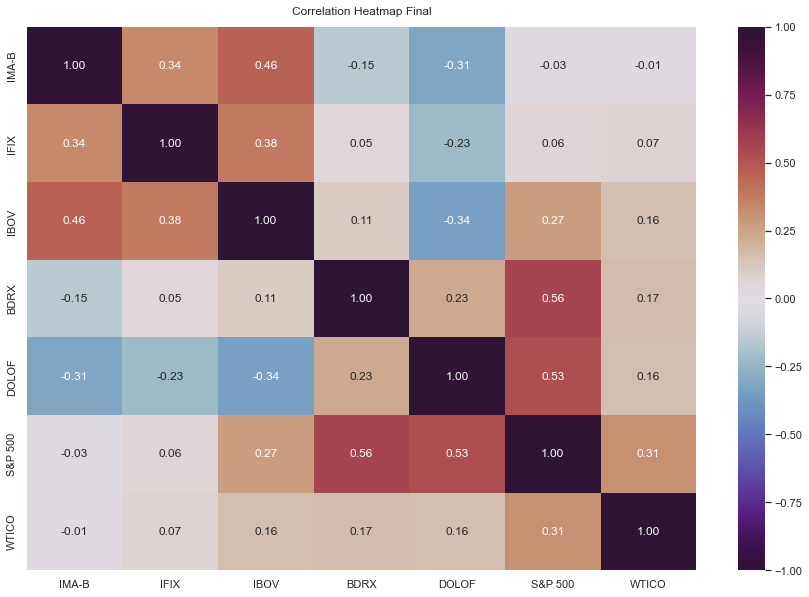

In [25]:
plt.figure(figsize=(15, 10))
phi = df3.loc[:str(yn+2)].corr()
print(f"Number of Tickers: {len(df3.columns)}")
h = sns.heatmap(phi, annot=True, fmt='.2f', vmin=-1, vmax=1, cmap='twilight_shifted');
h.set_title('Correlation Heatmap Final', fontdict={'fontsize':12}, pad=12);

### Rolling annualized (252 days) log returns

In [28]:
df_rolling_252d = df3.loc['2011':].add(1).rolling(252, min_periods=1).apply(np.prod).sub(1)
df_rolling_252d.describe()

,IMA-B,IFIX,IBOV,BDRX,DOLOF,S&P 500,WTICO
count,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000,2763.000000
mean,0.116999,0.102851,0.033262,0.246784,0.113833,0.234987,0.064071
std,0.093789,0.144895,0.189931,0.198235,0.166758,0.182575,0.398399
min,-0.136990,-0.238720,-0.372796,-0.376175,-0.256330,-0.192732,-0.772988
25%,0.049562,0.001086,-0.121184,0.109481,-0.005195,0.085199,-0.189587
50%,0.119145,0.063356,-0.008612,0.254048,0.099182,0.241594,0.007001
75%,0.179418,0.218682,0.177024,0.390844,0.187589,0.371839,0.180163
max,0.312515,0.492266,0.711359,1.031306,0.717551,0.874903,3.626848


### Box plots of Rolling annualized (252 days) log returns

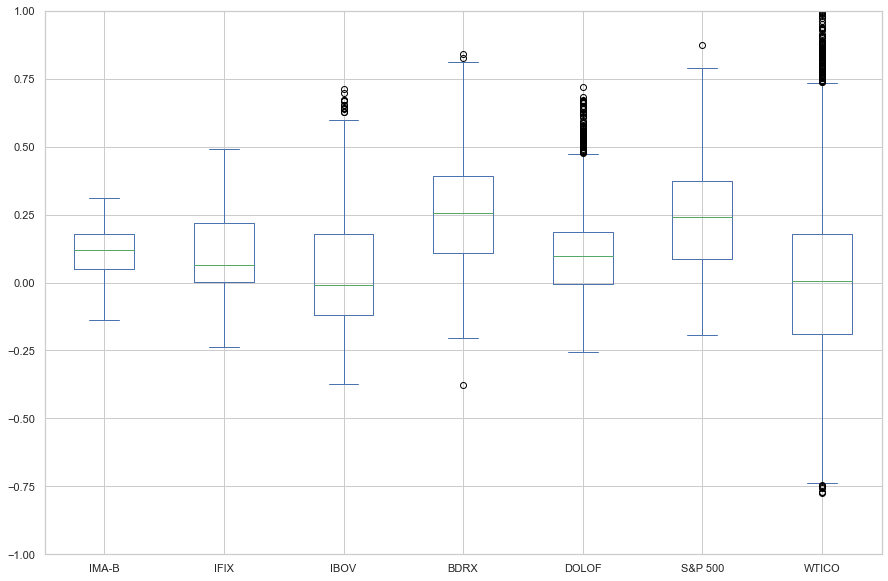

In [29]:
df_rolling_252d.plot.box(figsize=(15, 10), ylim=(-1, 1));

## Basic Markowitz for full date range

### Estimated Variance Matrix

We use `PyPortfolioOpt`to make a basic Markowitz portfolio with the Mean-Variance Optimization

### Expected Returns

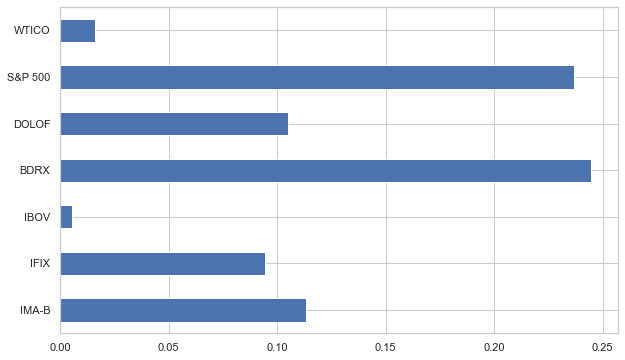

In [8]:
mu = expected_returns.mean_historical_return(df3, returns_data=True)
mu.plot.barh(figsize=(10,6));

### Estimate Portfolio Variance

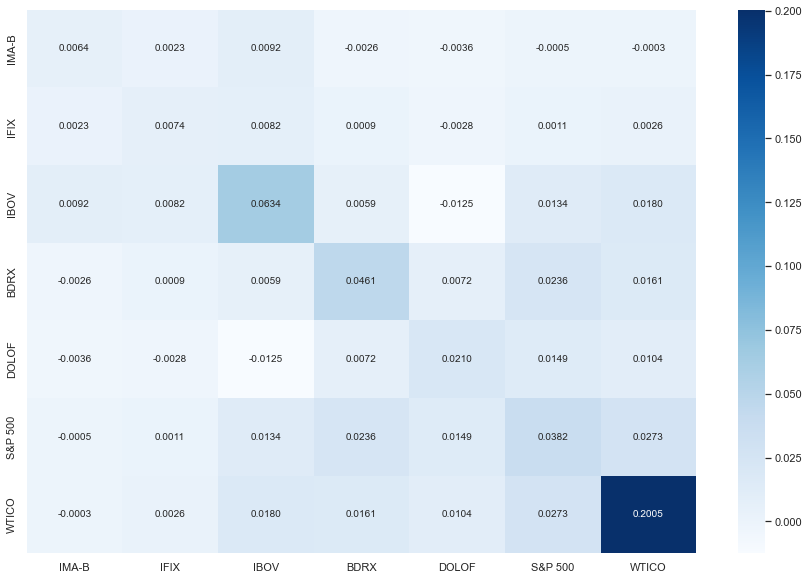

In [9]:
S = risk_models.sample_cov(df3, returns_data=True)

plt.figure(figsize=(15, 10));
sns.heatmap(S, annot=True, fmt='.4f', cmap='Blues');

### Optimize with Max Sharpe

Expected annual return: 12.8%
Annual volatility: 5.6%
Sharpe Ratio: 1.94


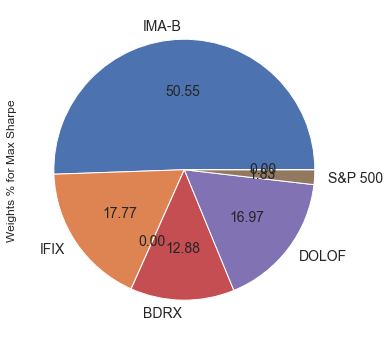

In [10]:
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
ex_return, ex_vol, sharpe = ef.portfolio_performance(verbose=True)

pd.Series(weights, name="Weights % for Max Sharpe").plot.pie(figsize=(6,6), autopct="%.2f", fontsize=14);

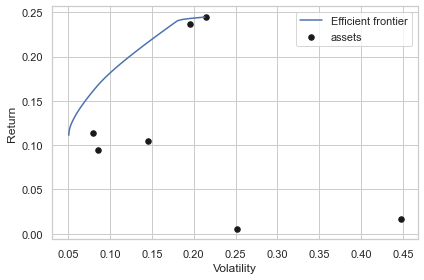

In [11]:
ef2 = EfficientFrontier(mu, S) # workaround for bug https://github.com/robertmartin8/PyPortfolioOpt/issues/373
plotting.plot_efficient_frontier(ef2);

## Rolling Markowitz Portfolio 3 years (252 * 3 days) for 1 year (252 days)

In [12]:
alpha = 5 / 100
ret_window_size = 252*3
fut_window_size = 252*1

def test_portfolio(returns, ret_size=252, fut_size=252, optim='max', bounds=None, 
                   rf=0.02, verbose=False):
    returns_on_window = returns.iloc[:ret_size, :]
    
    mu = expected_returns.mean_historical_return(returns_on_window, returns_data=True)
    S = risk_models.sample_cov(returns_on_window, returns_data=True)
    bounds = (0, 1) if not bounds else bounds
    ef = EfficientFrontier(mu, S, weight_bounds=bounds)

    if optim == 'max':
        ef.max_sharpe(risk_free_rate=rf)
    elif optim == 'min':
        ef.min_volatility()
    else:
        raise ValueError(f"optim must be set, invalid value: {optim}")
    
    er, vol, sharpe = ef.portfolio_performance(verbose=verbose, risk_free_rate=rf)
    w = ef.clean_weights()
    
    fut = calc_ticker_future(returns, w, ret_size, fut_size, rf)
    
    return dict(exp_return=er, exp_vol=vol, exp_sharpe=sharpe,
                portf_bound_il=bounds[0], portf_bound_ul=bounds[1],
                **fut,
                **w)

def test_portfolio_rolling(returns, ret_size, fut_size, **kwargs):
    window_size = ret_window_size + fut_window_size
    out = [test_portfolio(window, 
                       ret_size=ret_window_size, 
                       fut_size=fut_window_size, 
                       **kwargs ) 
           for window in returns.rolling(window_size, min_periods=window_size) 
           if len(window) >= window_size]
    del kwargs['verbose'], kwargs['bounds']
    return (pd.DataFrame.from_records(out)
            .assign(ret_size=ret_size, 
                    fut_size=fut_size, 
                    **kwargs)
           )

def calc_ticker_future(returns, w, ret_size, fut_size, rf=0.02):
    ws = pd.Series(w) if type(w) not in [int, float, np.ndarray] else w
    
    future_returns = returns.iloc[(ret_size+1):(ret_size+fut_size+1):, :]
    perf_returns = future_returns * ws
    perf_returns = perf_returns.add(1).cumprod(axis=0).sub(1).sum(axis=1)
    
    return dict(init_date=returns.index[0],
                start_date=perf_returns.index[0],
                end_date=perf_returns.index[0],
                mean_return=perf_returns.mean(),
                mean_sharpe=(perf_returns.mean() - rf) / perf_returns.std(),
                last_return=perf_returns.iloc[-1],
                last_sharpe=(perf_returns.iloc[-1] - rf) / perf_returns.std(),
                vol=perf_returns.std(),
                high = perf_returns.max(),
                low = perf_returns.min() )


In [13]:
%time

portfolios = test_portfolio_rolling(df3,
                            ret_size=ret_window_size, 
                            fut_size=fut_window_size, 
                            optim='max', bounds=None, rf=RISK_FREE, verbose=False)

print("Descriptive statiscts for Markowitz Portfolio")
portfolios.describe()

CPU times: total: 0 ns
Wall time: 0 ns
Descriptive statiscts for Markowitz Portfolio


,exp_return,exp_vol,exp_sharpe,portf_bound_il,portf_bound_ul,mean_return,mean_sharpe,last_return,last_sharpe,vol,...,IMA-B,IFIX,IBOV,BDRX,DOLOF,S&P 500,WTICO,ret_size,fut_size,rf
count,1756.000000,1756.000000,1756.000000,1756.0,1756.0,1756.000000,1756.000000,1756.000000,1756.000000,1756.000000,...,1756.000000,1756.000000,1.756000e+03,1756.000000,1756.000000,1756.000000,1756.000000,1756.0,1756.0,1.756000e+03
mean,0.165193,0.051371,2.882095,0.0,1.0,0.064919,0.867529,0.125865,2.304961,0.042294,...,0.398932,0.264982,7.175399e-07,0.193528,0.106262,0.035930,0.000366,756.0,252.0,2.170000e-02
std,0.029473,0.013029,0.591728,0.0,0.0,0.036640,0.832640,0.063628,1.042854,0.017264,...,0.095377,0.208168,3.006826e-05,0.117225,0.085677,0.060553,0.001646,0.0,0.0,6.940871e-18
min,0.111777,0.033122,1.797700,0.0,1.0,-0.027018,-3.084849,-0.047651,-4.371458,0.010700,...,0.219020,0.000000,0.000000e+00,0.025920,0.000000,0.000000,0.000000,756.0,252.0,2.170000e-02
25%,0.145071,0.042929,2.440777,0.0,1.0,0.036639,0.599485,0.080090,1.900401,0.028352,...,0.329008,0.000000,0.000000e+00,0.120590,0.061782,0.000000,0.000000,756.0,252.0,2.170000e-02
50%,0.159446,0.047608,2.796024,0.0,1.0,0.070860,1.104349,0.122338,2.562337,0.042616,...,0.398655,0.319110,0.000000e+00,0.146400,0.081310,0.000000,0.000000,756.0,252.0,2.170000e-02
75%,0.178115,0.062195,3.234169,0.0,1.0,0.087053,1.324992,0.166619,3.003515,0.053123,...,0.458135,0.446422,0.000000e+00,0.328143,0.122170,0.067175,0.000000,756.0,252.0,2.170000e-02
max,0.253955,0.087161,4.545354,0.0,1.0,0.174680,3.809900,0.285341,4.202311,0.081583,...,0.621460,0.618070,1.260000e-03,0.455630,0.389560,0.278550,0.014290,756.0,252.0,2.170000e-02


In [14]:
def calc_naive_portfolio_rolling(returns, ret_size, fut_size, rf=0.02, **kwargs):
    window_size = ret_window_size + fut_window_size
    
    w_1n = 1 / len(returns.columns)
    
    out = [ calc_ticker_future(window, w_1n, ret_size, fut_size, rf=rf)
           for window in returns.rolling(window_size, min_periods=window_size) 
           if len(window) >= window_size]
    
    return (pd.DataFrame.from_records(out)
            .assign(ret_size=ret_size, 
                    fut_size=fut_size, 
                    **kwargs)
           )

In [15]:
naive = calc_naive_portfolio_rolling(df3, ret_window_size, fut_window_size, rf=RISK_FREE)

print("Descriptive statiscts for Naive Portfolio")
naive.describe()

Descriptive statiscts for Naive Portfolio


,mean_return,mean_sharpe,last_return,last_sharpe,vol,high,low,ret_size,fut_size
count,1756.000000,1756.000000,1756.000000,1756.000000,1756.000000,1756.000000,1756.000000,1756.0,1756.0
mean,0.075332,0.920029,0.150155,2.274964,0.055267,0.174405,-0.054759,756.0,252.0
std,0.050995,0.753751,0.080189,1.020842,0.022086,0.074341,0.072477,0.0,0.0
min,-0.032077,-1.828204,-0.129864,-2.479380,0.027271,0.014357,-0.315948,756.0,252.0
25%,0.046684,0.484653,0.096670,1.711239,0.036187,0.121730,-0.068859,756.0,252.0
50%,0.066829,0.875083,0.150279,2.335054,0.053969,0.171788,-0.024265,756.0,252.0
75%,0.097700,1.434939,0.189152,2.973275,0.068260,0.215364,-0.007021,756.0,252.0
max,0.414763,3.444113,0.571669,4.854581,0.129862,0.613242,0.049109,756.0,252.0


In [16]:
def calc_random_portfolio_rolling(returns, ret_size, fut_size, rf=0.02, seed=42, **kwargs):
    window_size = ret_window_size + fut_window_size
    
    rng = np.random.default_rng(seed)
    i, j = returns.shape
    r = rng.integers(j, size=(j, i))
    
    w_returns = returns * (r / r.sum(axis=0)).T
    
    out = [ calc_ticker_future(window, 1, ret_size, fut_size, rf=rf)
           for window in w_returns.rolling(window_size, min_periods=window_size) 
           if len(window) >= window_size]
    
    return (pd.DataFrame.from_records(out)
            .assign(ret_size=ret_size, 
                    fut_size=fut_size, 
                    **kwargs)
           )

In [17]:
rand_portf = calc_random_portfolio_rolling(df3, ret_window_size, fut_window_size, seed=1234, rf=RISK_FREE)
print("Descriptive statiscts for Random Portfolio")
rand_portf.describe()

Descriptive statiscts for Random Portfolio


,mean_return,mean_sharpe,last_return,last_sharpe,vol,high,low,ret_size,fut_size
count,1756.000000,1756.000000,1756.000000,1756.000000,1756.000000,1756.000000,1756.000000,1756.0,1756.0
mean,0.074243,0.746951,0.149242,1.942207,0.061723,0.183088,-0.075492,756.0,252.0
std,0.064622,0.901125,0.103678,1.270373,0.024408,0.093492,0.089663,0.0,0.0
min,-0.069191,-2.244732,-0.160899,-3.034014,0.016778,-0.008117,-0.374385,756.0,252.0
25%,0.030972,0.220130,0.079687,1.296921,0.042973,0.112694,-0.101796,756.0,252.0
50%,0.060347,0.743839,0.134895,2.131309,0.059487,0.173832,-0.045615,756.0,252.0
75%,0.116412,1.418787,0.207338,2.843126,0.079303,0.244274,-0.008582,756.0,252.0
max,0.422894,3.093191,0.635402,4.828641,0.131495,0.652033,0.088158,756.0,252.0


In [18]:
# https://machinelearningmastery.com/statistical-hypothesis-tests-in-python-cheat-sheet/

cols = ['last_sharpe', 'last_return']
new_cols = ['portfolio_exp_sharpe', 'portfolio_sharpe', 'portfolio_return', 
            'naive_sharpe', 'naive_return', 'rand_sharpe', 'rand_return']
data = (pd.concat([portfolios.loc[:, ['exp_sharpe'] + cols], 
                  naive.loc[:, cols], 
                  rand_portf.loc[:, cols]], axis=1, ignore_index=True)
        .set_index(portfolios['start_date'])
        .rename(columns={i: col for i, col in enumerate(new_cols)}) )

data.filter(regex='sharpe').describe()

,portfolio_exp_sharpe,portfolio_sharpe,naive_sharpe,rand_sharpe
count,1756.000000,1756.000000,1756.000000,1756.000000
mean,2.882095,2.304961,2.274964,1.942207
std,0.591728,1.042854,1.020842,1.270373
min,1.797700,-4.371458,-2.479380,-3.034014
25%,2.440777,1.900401,1.711239,1.296921
50%,2.796024,2.562337,2.335054,2.131309
75%,3.234169,3.003515,2.973275,2.843126
max,4.545354,4.202311,4.854581,4.828641


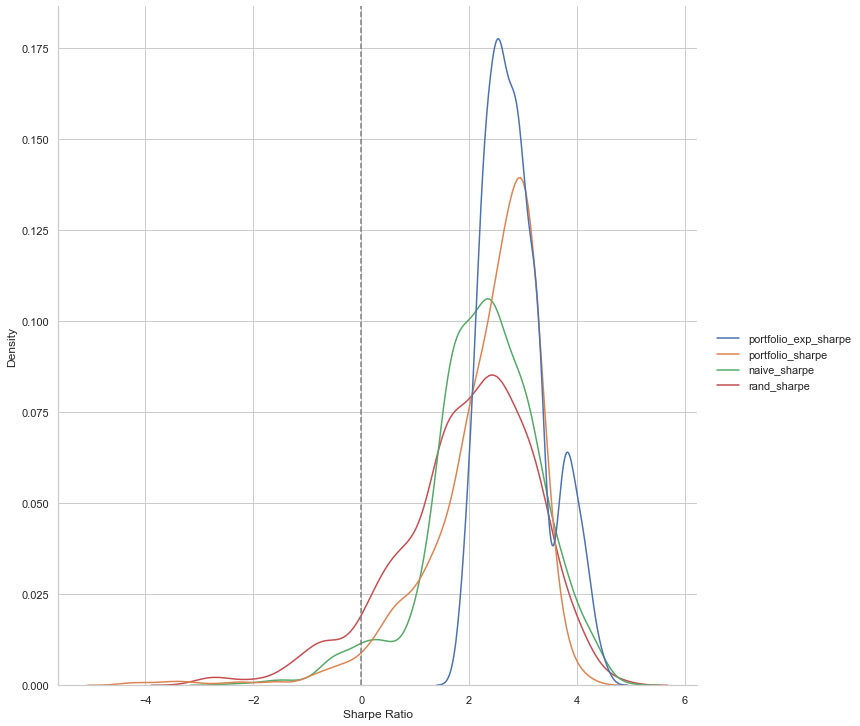

In [19]:
sns.displot(data.filter(regex='sharpe'), kind="kde", height=10);
plt.axvline(x = 0, color = '0.5', linestyle='--', label = '');
plt.xlabel('Sharpe Ratio');

In [20]:
data.filter(regex='return').describe()

,portfolio_return,naive_return,rand_return
count,1756.000000,1756.000000,1756.000000
mean,0.125865,0.150155,0.149242
std,0.063628,0.080189,0.103678
min,-0.047651,-0.129864,-0.160899
25%,0.080090,0.096670,0.079687
50%,0.122338,0.150279,0.134895
75%,0.166619,0.189152,0.207338
max,0.285341,0.571669,0.635402


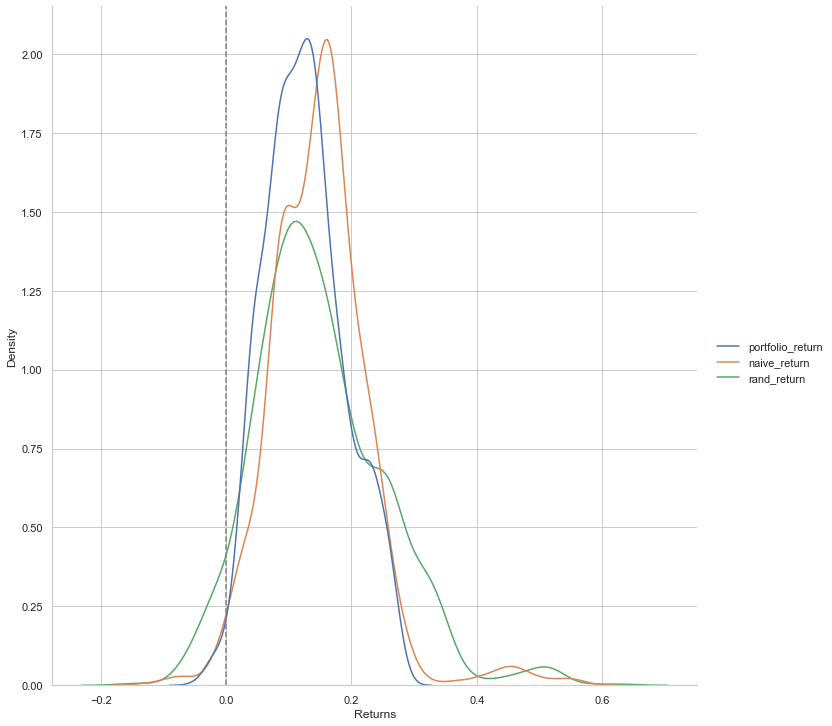

In [21]:
sns.displot(data.filter(regex='return'), kind="kde", height=10);
plt.axvline(x = 0, color = '0.5', linestyle='--', label = '');
plt.xlabel('Returns');

In [22]:
from scipy.stats import shapiro, wilcoxon
# Shapiro-Wilk Test
# H0: the sample has a Gaussian distribution.
# H1: the sample does not have a Gaussian distribution.
for col in data:
    stat, p = shapiro(data.loc[:, col])
    h = f"{'ACCEPET' if p > 0.05 else 'REJECT'} {col} has normal distribution"
    print('%s => stat=%.3f, p=%.4f' % (h, stat, p))

REJECT portfolio_exp_sharpe has normal distribution => stat=0.955, p=0.0000
REJECT portfolio_sharpe has normal distribution => stat=0.854, p=0.0000
REJECT portfolio_return has normal distribution => stat=0.987, p=0.0000
REJECT naive_sharpe has normal distribution => stat=0.969, p=0.0000
REJECT naive_return has normal distribution => stat=0.931, p=0.0000
REJECT rand_sharpe has normal distribution => stat=0.964, p=0.0000
REJECT rand_return has normal distribution => stat=0.967, p=0.0000


In [46]:
data_bs_mean = pd.concat([data.sample(frac=1, replace=True).mean() for i in range(1000)], axis=1).T
data_bs_mean.describe()

,portfolio_exp_sharpe,portfolio_sharpe,portfolio_return,naive_sharpe,naive_return,rand_sharpe,rand_return
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2.881557,2.304331,0.125795,2.274299,0.150052,1.941487,0.149163
std,0.014193,0.025520,0.001565,0.023917,0.001910,0.029181,0.002437
min,2.841883,2.223395,0.121324,2.184983,0.143705,1.853418,0.142045
25%,2.872166,2.287419,0.124740,2.258713,0.148713,1.922099,0.147413
50%,2.881217,2.303982,0.125764,2.274569,0.150032,1.940814,0.149166
75%,2.890707,2.321250,0.126809,2.290742,0.151375,1.960537,0.150784
max,2.925268,2.381548,0.130816,2.359493,0.155717,2.032459,0.155857


In [45]:

# Shapiro-Wilk Test
# H0: the sample has a Gaussian distribution.
# H1: the sample does not have a Gaussian distribution.
for col in data_bs_mean:
    stat, p = shapiro(data_bs_mean.loc[:, col])
    h = f"{'ACCEPET' if p > 0.05 else 'REJECT'} {col} has normal distribution"
    print('%s => stat=%.3f, p=%.4f' % (h, stat, p))

ACCEPET portfolio_exp_sharpe has normal distribution => stat=0.999, p=0.7121
ACCEPET portfolio_sharpe has normal distribution => stat=0.999, p=0.7629
ACCEPET portfolio_return has normal distribution => stat=0.998, p=0.4153
ACCEPET naive_sharpe has normal distribution => stat=0.998, p=0.4596
ACCEPET naive_return has normal distribution => stat=0.998, p=0.4959
ACCEPET rand_sharpe has normal distribution => stat=0.997, p=0.1015
ACCEPET rand_return has normal distribution => stat=0.997, p=0.1016


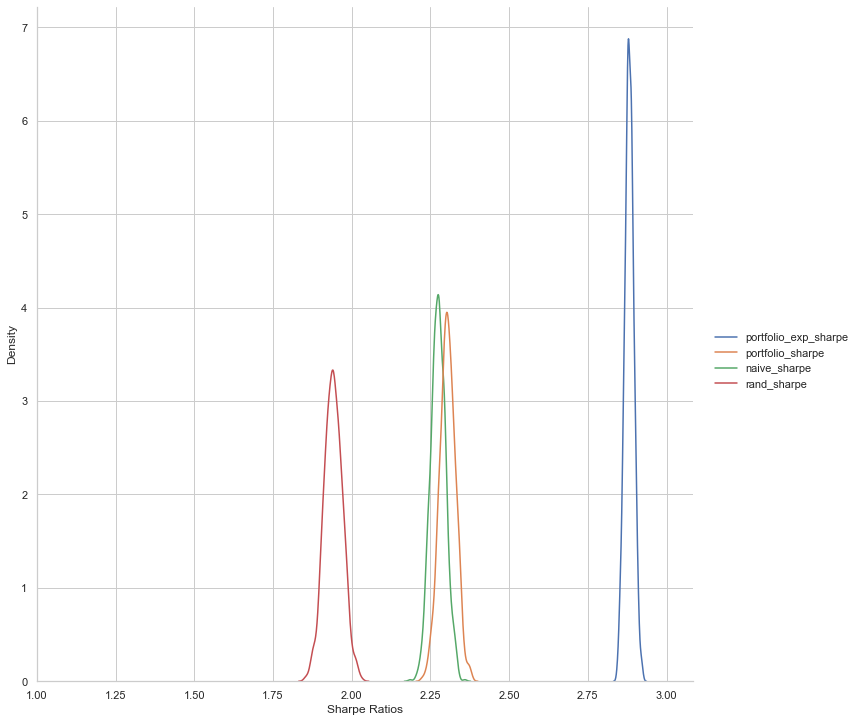

In [59]:
sns.displot(data_bs_mean.filter(regex='sharpe'), kind="kde", height=10);
plt.axvline(x = 0, color = '0.5', linestyle='--', label = '');
plt.xlabel('Sharpe Ratios');
plt.xlim(1);

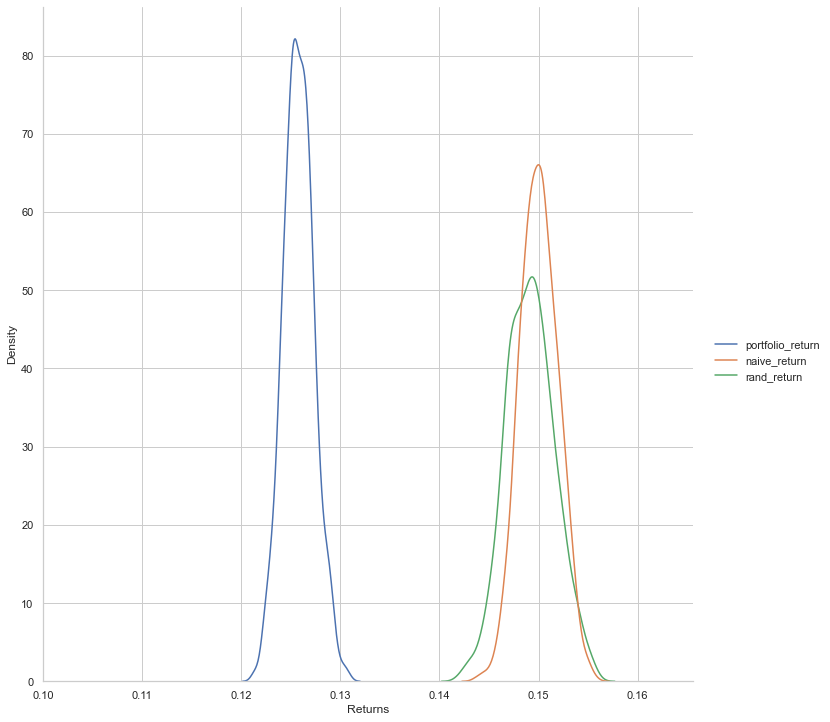

In [58]:
sns.displot(data_bs_mean.filter(regex='return'), kind="kde", height=10);
plt.axvline(x = 0, color = '0.5', linestyle='--', label = '');
plt.xlabel('Returns');
plt.xlim(.1);

In [54]:
pd.concat([data.quantile(alpha/2), data.quantile(1-(alpha/2))], axis=1)

,0.025,0.975
portfolio_exp_sharpe,1.989317,4.194109
portfolio_sharpe,-0.213924,3.531106
portfolio_return,0.017756,0.257443
naive_sharpe,-0.292359,4.098333
naive_return,0.012860,0.292476
rand_sharpe,-0.988722,3.994884
rand_return,-0.024851,0.359202


In [55]:
from scipy.stats import f_oneway

f_oneway(data.iloc[:, 0], data.iloc[:, 1], data.iloc[:, 3], data.iloc[:, 5])

F_onewayResult(statistic=261.4202915189496, pvalue=7.682348427011915e-161)

In [56]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
# TODO